# Graph-Embedded SIR Model using `Agents`

The SIR model tracks the ratio of Susceptible($S$), Infected($I$), Recovered($R$) individuals within a population. 

Here we add one more category of individuals: those who are infected, but do not know it (Asymptomatic?).

Transmission rate of infected and diagnosed is lower than infected and undetected. We also allow a fraction of recovered individuals to catch the disease again, meaning that recovering the disease does not bring full immunity.

## Packages

In [ ]:
] up

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  99.9 %Fetching: [======>                                  ]  12.7 %Fetching: [=========>                               ]  22.4 %>                         ]  37.2 %]  37.4 % [=====================>                   ]  52.3 %   ]  91.3 %Fetching: [======================================>  ]  94.6 %Fetching: [======================================>  ]  94.8 %Fetching: [=======================================> ]  95.0 %Fetching: [=======================================> ]  95.3 %Fetching: [=======================================> ]  96.0 %

  Installed DiffEqCallbacks ────── v2.13.5
  Installed SIMDPirates ────────── v0.8.17
  Installed DynamicalSystemsBase ─ v1.5.4
  Installed DrWatson ───────────── v1.14.6
  Installed Atom ───────────────── v0.12.18
  Installed Pluto ──────────────── v0.11.0
  Installed Agents ─────────────── v3.3.0
  Installed FiniteDiff ─────────── v2.5.1
  Installed OrdinaryDiffEq ─────── v5.42.0
  Installed Roots ──────────────── v1.0.4
  Installed SLEEFPirates ───────── v0.5.5
  Installed DiffEqNoiseProcess ─── v5.1.1
  Installed JuliaFormatter ─────── v0.6.7
  Installed ModelingToolkit ────── v3.14.1
  Installed ArrayInterface ─────── v2.11.0
  Installed VectorizationBase ──── v0.12.26
  Installed HTTP ───────────────── v0.8.17
  Installed ChainRulesCore ─────── v0.9.5
  Installed OffsetArrays ───────── v1.1.2
  Installed LoopVectorization ──── v0.8.19
  Installed Intervals ──────────── v1.4.1
  Installed SQLite ─────────────── v1.0.5


In [ ]:
# Data Management 
using DataFrames
using DrWatson: @dict

# Statistics
using Random
using Distributions: Poisson, DiscreteNonParametric

# Modelling
using Agents, LightGraphs
using LinearAlgebra: diagind

# Data Visualization
using Plots, AgentsPlots, PlotThemes
using InteractiveChaos;
#using Makie;

## Agent Type 

In [2]:
mutable struct Person <: AbstractAgent
    id::Int
    pos::Int
    days_infected::Int  # Number of days since is infected
    status::Symbol      # 1: S, 2: I, 3:R
end

## Model 

### Initialization

In [3]:
function model_initialization(;
    Ns,
    migration_rates,
    β_und,
    β_det,
    infection_period = 30,
    reinfection_probability = 0.05,
    detection_time = 14,
    death_rate = 0.02,
    Is = [zeros(Int, length(Ns) - 1)..., 1],
    seed = 0,
)

    Random.seed!(seed)
    @assert length(Ns) ==
    length(Is) ==
    length(β_und) ==
    length(β_det) ==
    size(migration_rates, 1) "length of Ns, Is, and B, and number of rows/columns in migration_rates should be the same "
    @assert size(migration_rates, 1) == size(migration_rates, 2) "migration_rates rates should be a square matrix"

    C = length(Ns)
    ## normalize migration_rates
    migration_rates_sum = sum(migration_rates, dims = 2)
    for c in 1:C
        migration_rates[c, :] ./= migration_rates_sum[c]
    end
    
    # Model Parameters
    properties = @dict(
        Ns,
        Is,
        β_und,
        β_det,
        β_det,
        migration_rates,
        infection_period,
        infection_period,
        reinfection_probability,
        detection_time,
        C,
        death_rate
    )
    
    # Ambient Space Instantiation
    space = GraphSpace(watts_strogatz(C, 4, 0.8, is_directed=true, seed=123)) # complete_digraph(C)
  
    # Model Instantiation
    model = ABM(Person, space; properties = properties)

    ## Add initial individuals
    for city in 1:C, n in 1:Ns[city]
        ind = add_agent!(city, model, 0, :S) # Susceptible
    end
    ## Add infected individuals
    for city in 1:C
        inds = get_node_contents(city, model)
        for n in 1:Is[city]
            agent = model[inds[n]]
            agent.status = :I # Infected
            agent.days_infected = 1
        end
    end
    return model
end

model_initialization (generic function with 1 method)

### Parameters

* `Ns`: a vector of population sizes per city. The amount of cities is just `C=length(Ns)`.
* `β_und`: a vector for transmission probabilities β of the infected but undetected per city. Transmission probability is how many susceptiple are infected per day by an infected individual. If social distancing is practiced, this number increases.
* `β_det`: an array for transmission probabilities β of the infected and detected per city. If hospitals are full, this number increases.
* `infection_period = 30`: how many days before a person dies or recovers.
* `detection_time = 14`: how many days before an infected person is detected.
* `death_rate = 0.02`: the probability that the individual will die after the infection_period.
* `reinfection_probability = 0.05`: The probabiity that a recovered person can get infected again.
* `migration_rates`: A matrix of migration probability per individual per day from one city to another.
* `Is = [zeros(C-1)..., 1]`: An array for initial number of infected but undetected people per city. This starts as only one infected individual in the last city.

Notice that all `Ns`, `β`, `Is` need to have the same length, as they are numbers for each city. We've tried to add values to the infection parameters similar to the ones you would hear on the news about COVID-19.

The good thing with Agent based models is that you could easily extend the model we implement here to also include age as the agent's property. This makes ABMs flexible and suitable for research of virus spreading.

In [4]:
function create_parameters(;
    C,
    max_travel_rate,
    infection_period = 30,
    reinfection_probability = 0.05,
    detection_time = 14,
    death_rate = 0.02,
    Is = [zeros(Int, C - 1)..., 1],
    seed = 19,
)

    Random.seed!(seed)
    Ns = rand(50:5000, C)
    β_und = rand(0.3:0.02:0.6, C)
    β_det = β_und ./ 10

    Random.seed!(seed)
    migration_rates = zeros(C, C)
    for c in 1:C
        for c2 in 1:C
            migration_rates[c, c2] = (Ns[c] + Ns[c2]) / Ns[c]
        end
    end
    maxM = maximum(migration_rates)
    migration_rates = (migration_rates .* max_travel_rate) ./ maxM
    migration_rates[diagind(migration_rates)] .= 1.0

    parameters = @dict(
        Ns,
        β_und,
        β_det,
        migration_rates,
        infection_period,
        reinfection_probability,
        detection_time,
        death_rate,
        Is
    )

    return parameters
end

create_parameters (generic function with 1 method)

### Instantiation

In [5]:
model_parameters = create_parameters(C = 8, max_travel_rate = 0.01)
model = model_initialization(; model_parameters...);

### Dynamics

#### Micro-Dynamics / Agent-Level

#### Macro-Dynamics / System-Level

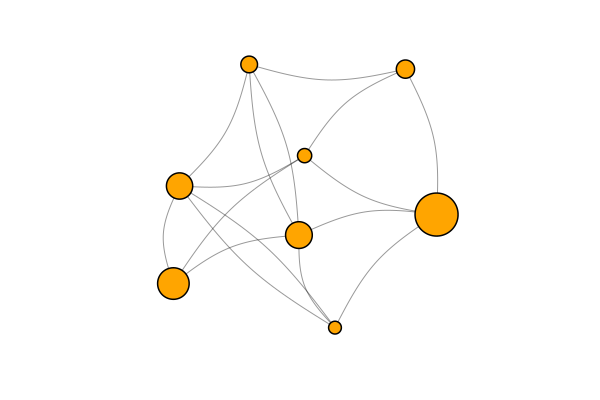

In [6]:
# Set Plot Parameters
plot_parameters = (node_size = 0.2, 
                   nodecolor = "orange", 
                   method = :star, 
                   linealpha = 0.4)

# Plot the initial state
plotabm(model; plot_parameters...)